In [1]:
from __future__ import print_function
import torch

In [2]:
x = torch.empty(5, 3)
print(x)
x = torch.rand(5, 3)
print(x)
print(x.size())
y = torch.rand(5, 3)
print(x + y)

tensor([[7.2053e+22, 4.7428e+30, 1.8580e-19],
        [1.4584e-19, 2.4755e-12, 4.0728e-11],
        [1.1704e-19, 1.3563e-19, 1.3563e-19],
        [4.5071e+16, 2.4754e-12, 4.0046e-11],
        [5.8253e-10, 8.2990e-33, 1.3563e-19]])
tensor([[0.0805, 0.8504, 0.3430],
        [0.4761, 0.2425, 0.9209],
        [0.3407, 0.3518, 0.8488],
        [0.2534, 0.6489, 0.2606],
        [0.3551, 0.5958, 0.2821]])
torch.Size([5, 3])
tensor([[0.8700, 1.7004, 0.4827],
        [1.4115, 0.8201, 1.0198],
        [1.0126, 0.7729, 1.0843],
        [0.9385, 1.1286, 0.4069],
        [0.8139, 0.5991, 0.7661]])


In [3]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!

tensor([[1.0805, 1.8504, 1.3430],
        [1.4761, 1.2425, 1.9209],
        [1.3407, 1.3518, 1.8488],
        [1.2534, 1.6489, 1.2606],
        [1.3551, 1.5958, 1.2821]], device='cuda:0')
tensor([[1.0805, 1.8504, 1.3430],
        [1.4761, 1.2425, 1.9209],
        [1.3407, 1.3518, 1.8488],
        [1.2534, 1.6489, 1.2606],
        [1.3551, 1.5958, 1.2821]], dtype=torch.float64)


> Forwards calculation follow-up and Backwards optimization

In [4]:
x = torch.ones(2, 2, requires_grad=True)
print(x)
y = x + 2
print(y)

print(y.grad_fn)

z = y * y * 3
out = z.mean()
print(z, out)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [5]:
out.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [6]:
# Jacobian product
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([-1022.0981,  -571.9418,  -678.3652], grad_fn=<MulBackward0>)


## Neural Nets

In [7]:
"""
A typical training procedure for a neural network is as follows:

Define the neural network that has some learnable parameters (or weights)
Iterate over a dataset of inputs
Process input through the network
Compute the loss (how far is the output from being correct)
Propagate gradients back into the network’s parameters
Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

print('---params---')
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

# Do it with a random input
print('---rand input---')
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

# Zero the gradient buffers of all parameters and backprops with random gradients:
print('---zero grad---')
net.zero_grad()
out.backward(torch.randn(1, 10))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
---params---
10
torch.Size([6, 1, 3, 3])
---rand input---
tensor([[ 0.0072,  0.0128, -0.0012, -0.0154, -0.0141, -0.0780,  0.0799, -0.1167,
          0.1057,  0.0141]], grad_fn=<AddmmBackward>)
---zero grad---


Recap:
+ torch.Tensor - A multi-dimensional array with support for autograd operations like backward(). Also holds the gradient w.r.t. the tensor.
+ nn.Module - Neural network module. Convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc.
+ nn.Parameter - A kind of Tensor, that is automatically registered as a parameter when assigned as an attribute to a Module.
+ autograd.Function - Implements forward and backward definitions of an autograd operation. Every Tensor operation creates at least a single Function node that connects to functions that created a Tensor and encodes its history.

In [8]:
# Loss function
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.2683, grad_fn=<MseLossBackward>)


Now, if you follow loss in the backward direction, using its .grad_fn attribute, you will see a graph of computations that looks like this
```python
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> view -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss
```

In [9]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [10]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0063, -0.0034,  0.0061, -0.0024, -0.0008,  0.0029])


In [11]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

## Training a classifier

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

 bird  frog   car truck


In [4]:
# Define CNN

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
# Define Loss Function 

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
# Train 

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.268
[1,  4000] loss: 1.908
[1,  6000] loss: 1.705
[1,  8000] loss: 1.585
[1, 10000] loss: 1.516
[1, 12000] loss: 1.474
[2,  2000] loss: 1.390
[2,  4000] loss: 1.380
[2,  6000] loss: 1.337
[2,  8000] loss: 1.322
[2, 10000] loss: 1.307
[2, 12000] loss: 1.277
Finished Training


In [7]:
# save
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

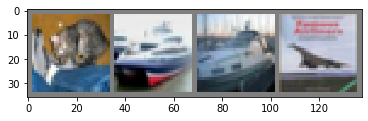

GroundTruth:    cat  ship  ship plane


In [8]:
# Test

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 72 %
Accuracy of  bird : 37 %
Accuracy of   cat : 32 %
Accuracy of  deer : 48 %
Accuracy of   dog : 35 %
Accuracy of  frog : 78 %
Accuracy of horse : 49 %
Accuracy of  ship : 79 %
Accuracy of truck : 46 %


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [14]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
inputs, labels = data[0].to(device), data[1].to(device)